# Titanic - Machine Learning from Disaster

The target is simple: use machine learning to create a model that predicts which passengers survived the Titanic shipwreck. The dataset was taken out from Kaggle: "Titanic - Machine Learning from Disaster".

### About the data

I have access to two similar datasets that include passenger information like name, age, gender, socio-economic class, etc. One dataset is titled train.csv and the other is titled test.csv.

Train.csv contains the details of a subset of the passengers on board (891 to be exact) and importantly, will reveal whether they survived or not.

The test.csv dataset contains similar information but does not disclose the “ground truth” for each passenger. 

Using the patterns in the train.csv data, I have to predict whether the other 418 passengers on board (found in test.csv) survived.

In [87]:
# Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [88]:
# Datasets
df_train=pd.read_csv("train.csv")
df_test=pd.read_csv("test.csv")
submission=pd.read_csv("gender_submission.csv")
print("Training shape:",df_train.shape," | Test shape:",df_test.shape)


Training shape: (891, 12)  | Test shape: (418, 11)


In [89]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [90]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [91]:
df_id = df_test["PassengerId"]
df_id.columns = df_test.columns
df_id

0       892
1       893
2       894
3       895
4       896
       ... 
413    1305
414    1306
415    1307
416    1308
417    1309
Name: PassengerId, Length: 418, dtype: int64

### Exploratory Data Analysis
Before building a model, I will analyze and explore our dataset in order to identify patters, missing values and other relevant stuff.

In [92]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Let´s find about duplicated and null info:

In [93]:
print(df_train.duplicated().sum())

0


In [94]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

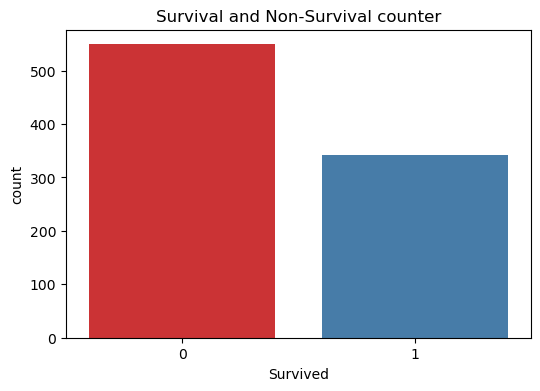

In [95]:
plt.figure(figsize=(6,4))
sns.countplot(x= "Survived", hue = "Survived", data = df_train, palette = "Set1", legend = None)
plt.title("Survival and Non-Survival counter")
plt.show()

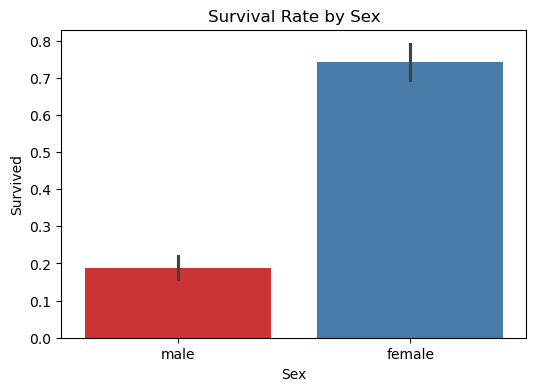

In [96]:
plt.figure(figsize=(6,4))
sns.barplot(x = "Sex", y = "Survived", hue = "Sex", data = df_train, palette = "Set1", legend = None)
plt.title("Survival Rate by Sex")
plt.show()

In [97]:
df_train["Sex"].value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

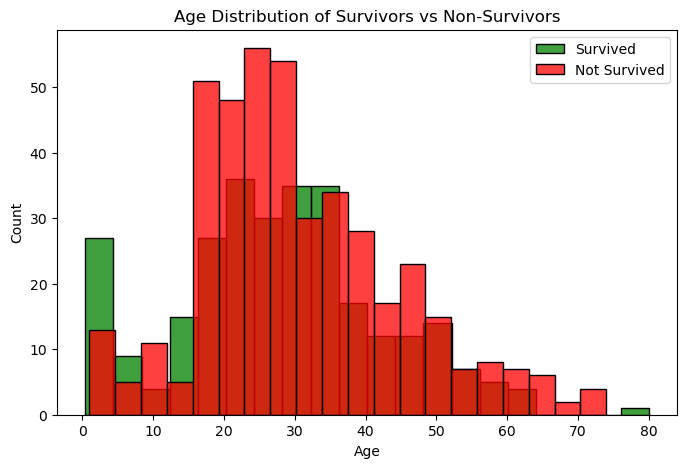

In [98]:
plt.figure(figsize=(8,5))
sns.histplot(df_train[df_train["Survived"]==1]["Age"], bins=20, color="green", label="Survived")
sns.histplot(df_train[df_train["Survived"]==0]["Age"], bins=20, color="red", label="Not Survived")
plt.legend()
plt.title("Age Distribution of Survivors vs Non-Survivors")
plt.show()

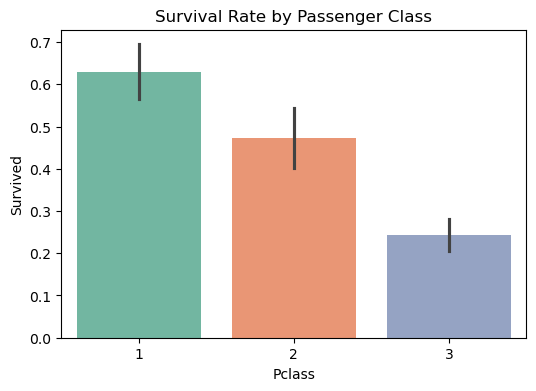

In [99]:
plt.figure(figsize=(6,4))
sns.barplot(x = "Pclass", y = "Survived", data = df_train, hue = "Pclass", palette = "Set2", legend = None)
plt.title("Survival Rate by Passenger Class")
plt.show()

I will drop irrelevant columns:

In [100]:
df_train = df_train.drop(columns=["PassengerId","Cabin","Fare","Ticket","Name"])
df_test = df_test.drop(columns=["PassengerId","Cabin","Fare","Ticket","Name"])
df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked
0,0,3,male,22.0,1,0,S
1,1,1,female,38.0,1,0,C
2,1,3,female,26.0,0,0,S
3,1,1,female,35.0,1,0,S
4,0,3,male,35.0,0,0,S


I am about to separate df_train in two datasets. X will have all info related to passengers except if the survived or not, because that info will be in Y.

In [101]:
X = df_train.drop(columns = ["Survived"])
Y = df_train.Survived

Before modelling, it is important to move from categorical values to numerical.

In [102]:
categorical_cols = ["Sex", "Embarked"]
encoder = OrdinalEncoder()
X[categorical_cols] = encoder.fit_transform(X[categorical_cols])
df_test[categorical_cols] = encoder.fit_transform(df_test[categorical_cols])
X.head()

,Pclass,Sex,Age,SibSp,Parch,Embarked
0,3,1.0,22.0,1,0,2.0
1,1,0.0,38.0,1,0,0.0
2,3,0.0,26.0,0,0,2.0
3,1,0.0,35.0,1,0,2.0
4,3,1.0,35.0,0,0,2.0


In [103]:
X.isnull().sum()

Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Embarked      2
dtype: int64

In [104]:
df_test.isnull().sum()

Pclass       0
Sex          0
Age         86
SibSp        0
Parch        0
Embarked     0
dtype: int64

In [105]:
# I impute using the mean by default
imputer=SimpleImputer()
x_transformed=pd.DataFrame(imputer.fit_transform(X))
x_transformed.columns=X.columns

df_test_transformed=pd.DataFrame(imputer.fit_transform(df_test))
df_test_transformed.columns=df_test.columns

### Model Building
I will use a random forest classifier because it combines multiple decision trees to create a robust and accurate model, reducing the risk of overfitting.

In [106]:
rf = RandomForestClassifier(random_state=42)
rf_scores = cross_val_score(rf, x_transformed, Y, cv=5)
print(f"Random Forest CV Accuracy: {rf_scores.mean():.3f}")

Random Forest CV Accuracy: 0.808


Using Random Forest we can see which features influenced the most:

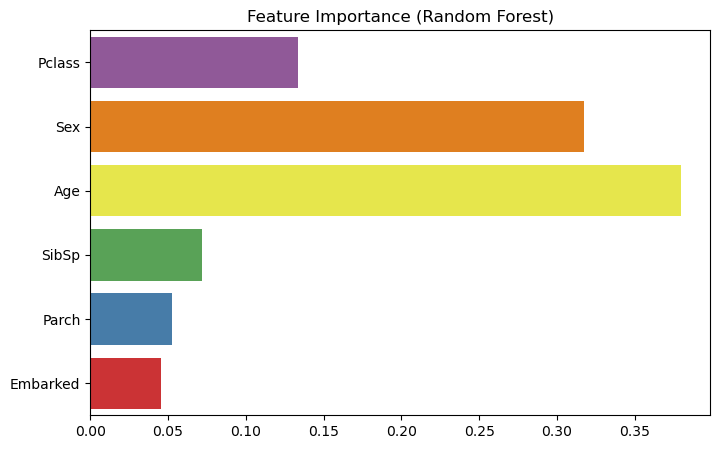

In [107]:
rf.fit(x_transformed, Y)
importances = rf.feature_importances_
features = x_transformed.columns

plt.figure(figsize=(8,5))
sns.barplot(x=importances, y=features, hue=importances, palette="Set1", legend=None)
plt.title("Feature Importance (Random Forest)")
plt.ylabel("")
plt.show()

In [108]:
# Test predictions
rf.fit(x_transformed, Y)
predictions = rf.predict(df_test_transformed)

### Conclusions
* Women had a higher survival rate than men.
* 1st Class passengers had better survival rate than 3rd Class.
* As passengers’ age increases, it is more likely that they will not survive.

### Submission

In [112]:
output=pd.DataFrame({'passengerId':submission.PassengerId, 'survived':predictions})
output.to_csv('submission.csv', index=False)
print("File created.")

File created.
